In [1]:
# data preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
from datetime import datetime
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
%matplotlib inline

In [12]:
df = pd.read_csv('/content/sample_data/household_power_consumption.txt', 
                 parse_dates={'dt' : ['Date', 'Time']}, sep=";", infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [13]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [15]:
df.shape

(2075259, 7)

In [16]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [17]:
# resampling so that the frequency becomes hourly and taking mean
df = df.resample('H').mean()


In [18]:
# further resampling so that the frequency becomes daily and taking mean
df = df.resample('D').mean()


In [35]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16,3.120298,0.096233,236.152341,13.369524,0.000000,1.330159,12.692063
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999312,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972


In [36]:
len(df)

1442

In [111]:
dataset_train_actual = df.copy()

In [112]:
dataset_train_actual.isnull().sum()

Global_active_power      9
Global_reactive_power    9
Voltage                  9
Global_intensity         9
Sub_metering_1           9
Sub_metering_2           9
Sub_metering_3           9
dtype: int64

In [113]:
dataset_train_actual = dataset_train_actual.fillna(dataset_train_actual.mean())

In [114]:
dataset_train_actual = dataset_train_actual.reset_index()

In [115]:
dataset_train_actual.isnull().sum()

dt                       0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [116]:
dataset_train_actual.head()

,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,3.120298,0.096233,236.152341,13.369524,0.000000,1.330159,12.692063
1,2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2,2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
3,2006-12-19,1.157079,0.104821,241.999312,4.926389,0.582639,5.279167,4.303472
4,2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972


In [117]:
dataset_train_actual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   dt                     1442 non-null   datetime64[ns]
 1   Global_active_power    1442 non-null   float64       
 2   Global_reactive_power  1442 non-null   float64       
 3   Voltage                1442 non-null   float64       
 4   Global_intensity       1442 non-null   float64       
 5   Sub_metering_1         1442 non-null   float64       
 6   Sub_metering_2         1442 non-null   float64       
 7   Sub_metering_3         1442 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 90.2 KB


In [ ]:
dataset_train_timeindex = dataset_train_actual.set_index('dt')

Step #1. Read data

In [118]:
dataset_train = dataset_train_actual.copy()

In [119]:

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[2:8]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['dt'])
datelist_train = [date for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (1442, 8)
All timestamps == 1442
Featured selected: ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']




Step #2. Data pre-processing

Removing all commas and convert data to matrix shape format.


In [75]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1442, 7).


array([[3.12029841e+00, 9.62333333e-02, 2.36152341e+02, ...,
        0.00000000e+00, 1.33015873e+00, 1.26920635e+01],
       [2.35448611e+00, 1.56948611e-01, 2.40087028e+02, ...,
        1.41180556e+00, 2.90763889e+00, 9.26458333e+00],
       [1.53043472e+00, 1.12355556e-01, 2.41231694e+02, ...,
        7.38194444e-01, 1.82013889e+00, 9.73472222e+00],
       ...,
       [1.24739444e+00, 9.19861111e-02, 2.40030965e+02, ...,
        7.61111111e-01, 1.97777778e+00, 8.48888889e+00],
       [9.93863889e-01, 8.06444444e-02, 2.41536257e+02, ...,
        7.47222222e-01, 2.95833333e-01, 3.52222222e+00],
       [1.16771212e+00, 9.15348485e-02, 2.40265076e+02, ...,
        8.18181818e-01, 2.91666667e-01, 7.56742424e+00]])

In [76]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[ 4.83789162],
       [ 3.01106956],
       [ 1.04531992],
       ...,
       [ 0.37013591],
       [-0.23465356],
       [ 0.18005614]])

In [77]:
# Creating a data structure with 72 timestamps and 1 output
X_train = []
y_train = []

n_future = 30   # Number of days we want top predict into the future
n_past = 72     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1341, 72, 7).
y_train shape == (1341, 1).



PART 2. Create a model. Training
Step #3. Building the LSTM based Neural Network


In [91]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 7]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  #tf.keras.layers.LSTM(128),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
  #tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1),
  # tf.keras.layers.Dense(3,kernel_initializer=tf.initializers.zeros),
  tf.keras.layers.Lambda(lambda x: x * 200),
  #tf.keras.layers.Reshape([24, 3])
])
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])



In [92]:


# %%time
# es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

# tb = TensorBoard('logs')

In [93]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 32)          704       
_________________________________________________________________
bidirectional_18 (Bidirectio (None, None, 64)          16640     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
_________________________________________________________________
lambda_9 (Lambda)            (None, 1)                 0         
Total params: 42,241
Trainable params: 42,241
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
34/34 [==============================] - 11s 159ms/step - loss: 13.6554 - mse: 330.1908 - val_loss: 6.4037 - val_mse: 69.3121
Epoch 2/100
34/34 [==============================] - 3s 94ms/step - loss: 4.5704 - mse: 45.6390 - val_loss: 4.8218 - val_mse: 41.9914
Epoch 3/100
34/34 [==============================] - 3s 95ms/step - loss: 3.6575 - mse: 28.3352 - val_loss: 3.3810 - val_mse: 21.2139
Epoch 4/100
34/34 [==============================] - 3s 98ms/step - loss: 2.5377 - mse: 14.2053 - val_loss: 2.7990 - val_mse: 15.6302
Epoch 5/100
34/34 [==============================] - 3s 96ms/step - loss: 2.0723 - mse: 10.5098 - val_loss: 2.5449 - val_mse: 13.5446
Epoch 6/100
34/34 [==============================] - 3s 95ms/step - loss: 2.0644 - mse: 10.2807 - val_loss: 2.3108 - val_mse: 12.0982
Epoch 7/100
34/34 [==============================] - 3s 94ms/step - loss: 1.8287 - mse: 8.4168 - val_loss: 2.0128 - val_mse: 9.1118
Epoch 8/100
34/34 [==============================] - 3s 95ms

In [95]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [97]:
datelist_train[-1]

Timestamp('2010-11-26 00:00:00')

In [96]:
datelist_future_

[datetime.date(2010, 11, 26),
 datetime.date(2010, 11, 27),
 datetime.date(2010, 11, 28),
 datetime.date(2010, 11, 29),
 datetime.date(2010, 11, 30),
 datetime.date(2010, 12, 1),
 datetime.date(2010, 12, 2),
 datetime.date(2010, 12, 3),
 datetime.date(2010, 12, 4),
 datetime.date(2010, 12, 5),
 datetime.date(2010, 12, 6),
 datetime.date(2010, 12, 7),
 datetime.date(2010, 12, 8),
 datetime.date(2010, 12, 9),
 datetime.date(2010, 12, 10),
 datetime.date(2010, 12, 11),
 datetime.date(2010, 12, 12),
 datetime.date(2010, 12, 13),
 datetime.date(2010, 12, 14),
 datetime.date(2010, 12, 15),
 datetime.date(2010, 12, 16),
 datetime.date(2010, 12, 17),
 datetime.date(2010, 12, 18),
 datetime.date(2010, 12, 19),
 datetime.date(2010, 12, 20),
 datetime.date(2010, 12, 21),
 datetime.date(2010, 12, 22),
 datetime.date(2010, 12, 23),
 datetime.date(2010, 12, 24),
 datetime.date(2010, 12, 25)]

In [98]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [108]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Global_active_power']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Global_active_power']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
# PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)



In [110]:
PREDICTIONS_FUTURE

,Global_active_power
2010-11-26,0.819904
2010-11-27,1.145970
2010-11-28,0.968319
2010-11-29,1.327052
2010-11-30,1.062297
2010-12-01,0.582126
2010-12-02,0.842254
2010-12-03,0.843370
2010-12-04,0.889366
2010-12-05,1.350370


In [109]:
PREDICTION_TRAIN

,Global_active_power
2007-06-07,0.980713
2007-06-08,1.020107
2007-06-09,1.033044
2007-06-10,1.118484
2007-06-11,1.297095
...,...
2010-11-22,0.615036
2010-11-23,0.589363
2010-11-24,1.100227
2010-11-25,1.220607



Step #6. Visualize the Predictions


Text(0, 0.5, 'Stock Price Value')

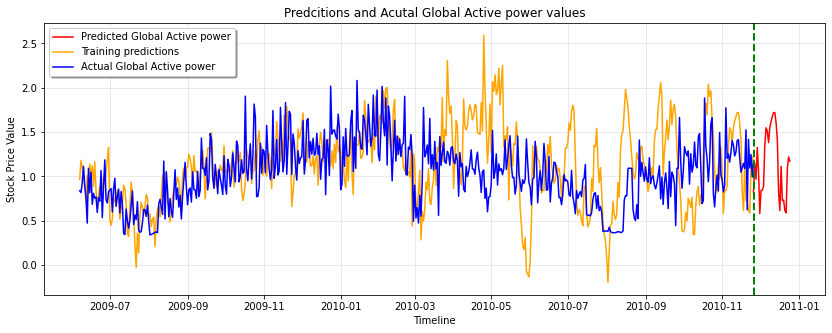

In [128]:
# Set plot size 
# from pylab import rcParams
plt.rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2009-06-07'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Global_active_power'], color='r', label='Predicted Global Active power')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Global_active_power'], color='orange', label='Training predictions')
plt.plot(dataset_train_timeindex.loc[START_DATE_FOR_PLOTTING:].index, dataset_train_timeindex.loc[START_DATE_FOR_PLOTTING:]['Global_active_power'], color='b', label='Actual Global Active power')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Global Active power values', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
# plt.xticks(rotation=45, fontsize=8)
# plt.show()

(1e-08, 0.0001, 0.0, 30.0)

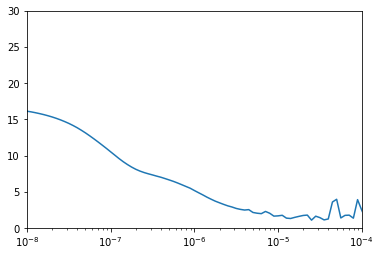

In [81]:
import matplotlib.pyplot as plt

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])